# Image labeller with persistence (example)

This notebook will demonstrate the follwing:

- using the image labelling tool as an IPython Notebook plugin
- rendering labels to create edge maps and label images
- extracting images of individual objects

It will also describe the label JSON file format.

In [1]:
import pathlib, math

import numpy as np
from matplotlib import pyplot as plt

from image_labelling_tool import labelled_image, labelling_tool

## Load the labels

Lets get the image `foxglove.jpg` that comes with some labels pre-defined.

This is the image we are working with (if you see a broken link icon and you are viewing this on GitHub, visit the image URL to view it):

![Foxglove image](./images/foxglove.jpg "Foxgloves")


In [2]:
# Load in .JPG images from the 'images' directory.
# This will get us a list of `labelled_image.LabelledImage` instances
labelled_images = labelled_image.LabelledImage.for_directory('images', image_filename_patterns=['*.jpg'])
print('Loaded {0} images'.format(len(labelled_images)))

# `LabelledImage` instances have two attribtes:
#     `image_source`: the image source represents the image being labelled and can access its path,
#         binary data, PIL/Array image and size in pixels
#     `labels_store`: the labels store loads and saves labels to disk or uses an in-memory represntation.
#
# See the `labelled_image` module for more)
#
# `image_source` will be a `labelled_image.FileImageSource`, that has an `image_path` attribute
# that is the path of the image as a `pathlib.Path`.
#
# Use this to find the labelled image for 'foxglove.jpg':
for limg in labelled_images:
    if limg.image_source.image_path.name.lower() == 'foxglove.jpg':
        labelled_img = limg
        
print('Image is at: {}'.format(labelled_img.image_source.image_path))

# We can get the size of the image through `image_source.image_size`:
image_shape = labelled_img.image_source.image_size
print('image_shape={}'.format(image_shape))

# To access labels as an `ImageLabel` instance you can:
# - go via the labels store: `labelled_img.labels_store.get_wrapped_labels().labels`
# - use the `wrapped_labels` convenience property: `labelled_img.wrapped_labels.labels`
# - use the `labels` convenience property: `labelled_img.labels`
# Use the last option as its the quickest:
labels = labelled_img.labels
print('Lables are represented as {}'.format(type(labels)))

Loaded 4 images
Image is at: D:\packages\image-labelling-tool\images\foxglove.jpg
image_shape=(614, 819)
Lables are represented as <class 'image_labelling_tool.labelling_tool.ImageLabels'>


#### Types

`labelled_images` is a list of `PersistentLabelledImage` instances. The `PersistentLabelledImage` class derives from `AbsractLabelledImage`. These classes pair images with corresponding labels.

`PersistentLabelledImage` handles images and corresponding labels stored in files. The images are regular image files and the labels are `json` files that end in the `__labels` prefix; the image `cat.jpg` will have a labels file `cat__labels.json` alongside it. `PersistentLabelledImage` transparently loads an image when accessing its pixel content and loads or save labels when the `labels` attribute is accessed or modified.

Labels are represented by the `ImageLabels` class that directly represents the labels in vector form and provides methods to work with them.

#### Get a histogram of the label classes used

We can start by getting a histogram of the classes used. The `label_class_histogram` method is defined on the `ImageLabels` class. The `AbsractLabelledImage` class wraps it:

In [3]:
labels.label_class_histogram()

{'flower': 19, 'leaf': 5, 'stem': 1}

## Rendering a semantic segmentation map

We can create a semantic segmentation map with the `render_label_classes` method.

As seen in the *Example Tool* cell above we have three classes; `flower`, `leaf` and `stem`.

The `label_classes` specifies how class names should be mapped to values in the image. It can either be a dictionary of `{class_name: class_index}` or it can be a sequence of class names. Label classes not listed in `label_classes` will be ignored. For example, lets render all the labels.

First, lets use a dictionary for `class_labels`:

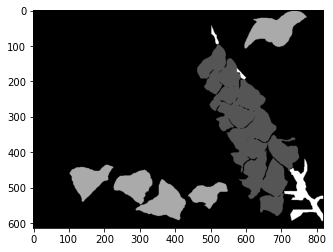

In [4]:
labels_2d = labels.render_label_classes(
    label_classes={'flower' : 1, 'leaf' : 2, 'stem' : 3}, image_shape=image_shape, multichannel_mask=False)
plt.imshow(labels_2d, cmap='gray')
plt.show()

`class_labels` as a sequence:

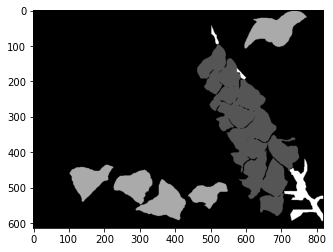

In [5]:
labels_2d = labels.render_label_classes(
    label_classes=['flower', 'leaf', 'stem'], image_shape=image_shape, multichannel_mask=False)
plt.imshow(labels_2d, cmap='gray')
plt.show()

When using a sequence for `class_labels`, re-ordering changes the label values:

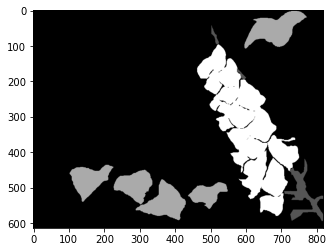

In [6]:
labels_2d = labels.render_label_classes(
    label_classes=['stem', 'leaf', 'flower'], image_shape=image_shape, multichannel_mask=False)
plt.imshow(labels_2d, cmap='gray')
plt.show()

You can render a subset of the labels used in the image; just the flowers:

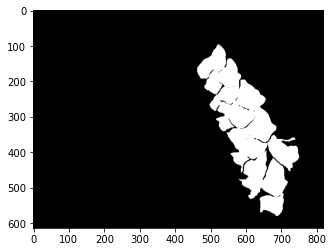

In [7]:
labels_2d = labels.render_label_classes({'flower': 1}, image_shape=image_shape, multichannel_mask=False)
plt.imshow(labels_2d, cmap='gray')
plt.show()

Again using a sequence:

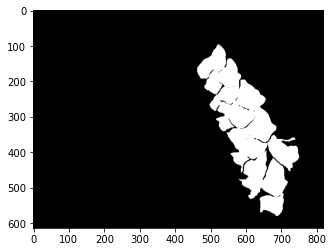

In [8]:
labels_2d = labels.render_label_classes(['flower'], image_shape=image_shape, multichannel_mask=False)
plt.imshow(labels_2d, cmap='gray')
plt.show()

If `label_classes` is a sequence, each item can also be a list of classes. This will result in the same value being used for multiple classes in the image. Lets render the natural featues - lake and trees - as one value and the non-natural - buildings - as another:

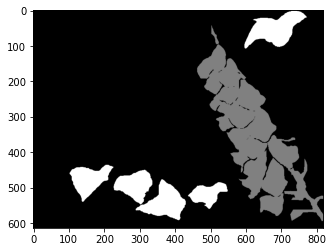

In [9]:
labels_2d = labels.render_label_classes(
    label_classes=[['flower', 'stem'], 'leaf'], image_shape=image_shape, multichannel_mask=False)
plt.imshow(labels_2d, cmap='gray')
plt.show()

Setting the `fill` parameter to `False` results in outlines being rendered:

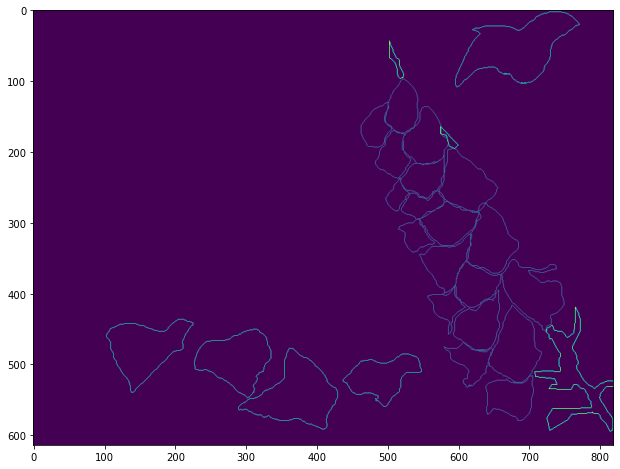

In [10]:
labels_2d = labels.render_label_classes(
    label_classes={'flower' : 1, 'leaf' : 2, 'stem' : 3}, image_shape=image_shape,
    multichannel_mask=False, fill=False)
plt.figure(figsize=(12,8))
plt.imshow(labels_2d)
plt.show()

Setting the `multichannel_mask` parameter to `True` will result in a multi-channel mask image in the form of a 3D array. It will have one channel for each item in `label_classes`. Note the class indices are 0-based, corresponding to a layer/channel in the image stack. Pixels will have either a value of `0` or `1` in a given channel indicating presence of a label in that class:

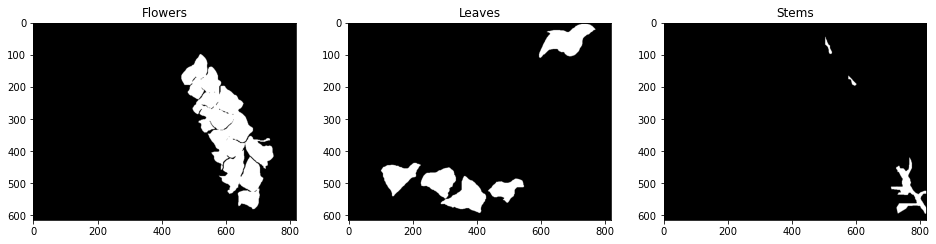

In [11]:
labels_2dn = labels.render_label_classes(
    label_classes={'flower' : 0, 'leaf' : 1, 'stem' : 2},
    image_shape=image_shape, multichannel_mask=True)
plt.figure(figsize=(16,4))

plt.subplot(1,3,1)
plt.title('Flowers')
plt.imshow(labels_2dn[:,:,0], cmap='gray')

plt.subplot(1,3,2)
plt.title('Leaves')
plt.imshow(labels_2dn[:,:,1], cmap='gray')

plt.subplot(1,3,3)
plt.title('Stems')
plt.imshow(labels_2dn[:,:,2], cmap='gray')
plt.show()

## Rendering instance segmentaion maps

The `render_label_instances` method assigns a different label value to each individual object. It returns a tuple of two values; the first is a label image as a 2D array where each pixel gives the index of the label and the second is a 1D array that gives the class index of each label. The `label_classes` parameter functions as with the `render_label_classes` method. Note that the class indices given to `label_classes` are 1-based so that all classes appear in the class map.

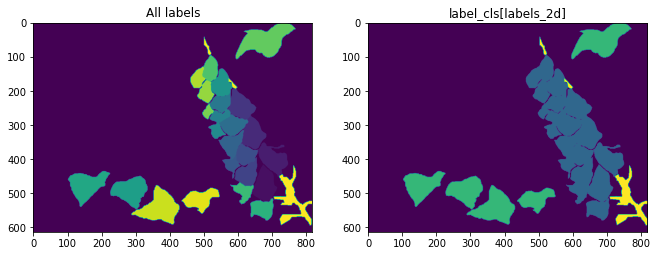

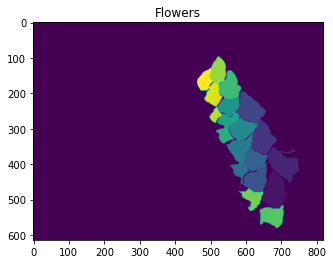

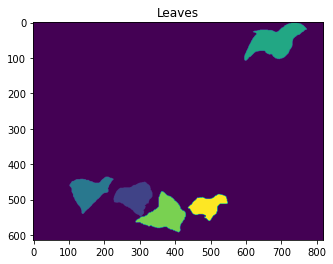

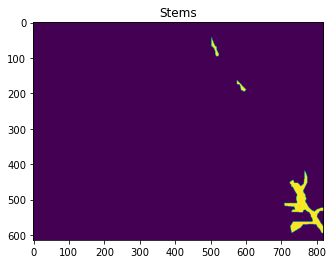

In [12]:
labels_2d, label_cls = labels.render_label_instances(
    label_classes={'flower' : 1, 'leaf' : 2, 'stem' : 3}, image_shape=image_shape)
plt.figure(figsize=(11, 4))
plt.subplot(1, 2, 1)
plt.title('All labels')
plt.imshow(labels_2d)

plt.subplot(1, 2, 2)
plt.title('label_cls[labels_2d]')
plt.imshow(label_cls[labels_2d])
plt.show()

# flowers
labels_2d, label_cls = labels.render_label_instances(label_classes={'flower' : 1}, image_shape=image_shape)
plt.figure()
plt.title('Flowers')
plt.imshow(labels_2d)
plt.show()
# leaves
labels_2d, label_cls = labels.render_label_instances(label_classes={'leaf' : 1}, image_shape=image_shape)
plt.figure()
plt.title('Leaves')
plt.imshow(labels_2d)
plt.show()
# stems
labels_2d, label_cls = labels.render_label_instances(label_classes={'stem' : 1}, image_shape=image_shape)
plt.figure()
plt.title('Stems')
plt.imshow(labels_2d)
plt.show()


Setting the `fill` parameter to `False` results in an outline image as before:

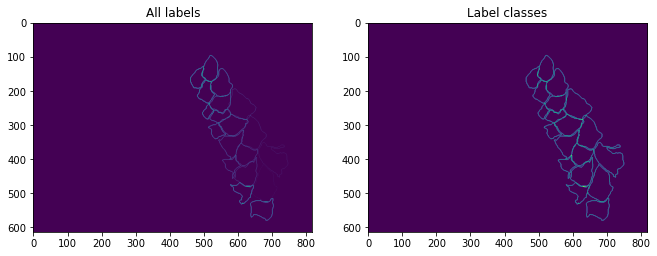

In [13]:
# Only render trees so that we can show one large image, otherwise the 1-pixel-wide outlines
# will be difficult to see:
labels_2d, label_cls = labels.render_label_instances(
    label_classes={'flower' : 1}, image_shape=image_shape, fill=False)
plt.figure(figsize=(11, 4))
plt.subplot(1, 2, 1)
plt.title('All labels')
plt.imshow(labels_2d)

plt.subplot(1, 2, 2)
plt.title('Label classes')
plt.imshow(label_cls[labels_2d])
plt.show()


Setting the `multichannel_mask` parameter to `True` results in an image with one channel per label. This would
be suitable for training the [PyTorch Mask-RCNN](https://pytorch.org/docs/stable/torchvision/models.html#mask-r-cnn) model:

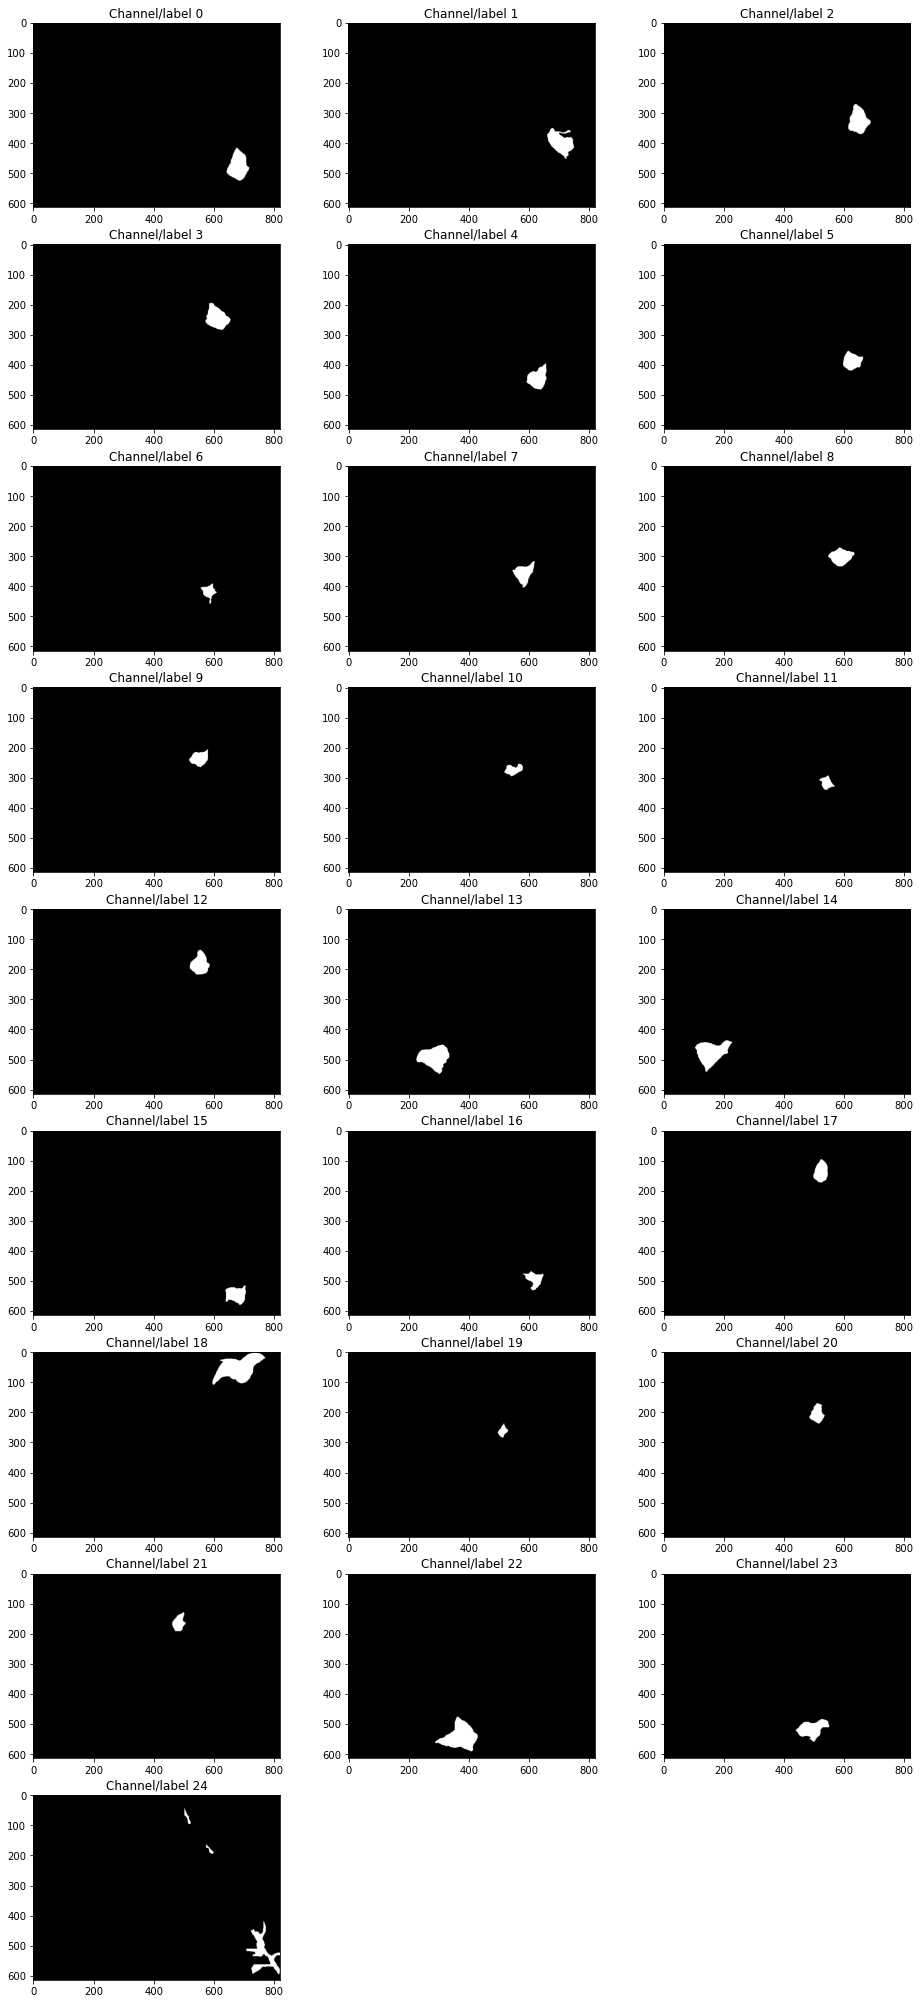

In [14]:
labels_2d, label_cls = labels.render_label_instances(
    label_classes={'flower' : 1, 'leaf' : 2, 'stem' : 3}, image_shape=image_shape, multichannel_mask=True)

COLUMNS = 3
ROWS = labels_2d.shape[2] // COLUMNS
if labels_2d.shape[2] % COLUMNS > 0:
    ROWS += 1

plt.figure(figsize=(16, 4 * ROWS))
for i in range(labels_2d.shape[2]):
    plt.subplot(ROWS, COLUMNS, i + 1)
    plt.title('Channel/label {}'.format(i))
    plt.imshow(labels_2d[:, :, i], cmap='gray')
plt.show()

## Extracting images of labelled objects

The `extract_label_images` method extracts the pixels covered by each individual labelled object from the original image. The `label_class_set` parameter specifies the classes of objects that should be rendered; objects whoses classes are not listed are not rendered. It can also be `None` to render all objects of all classes. It returns a list of images:

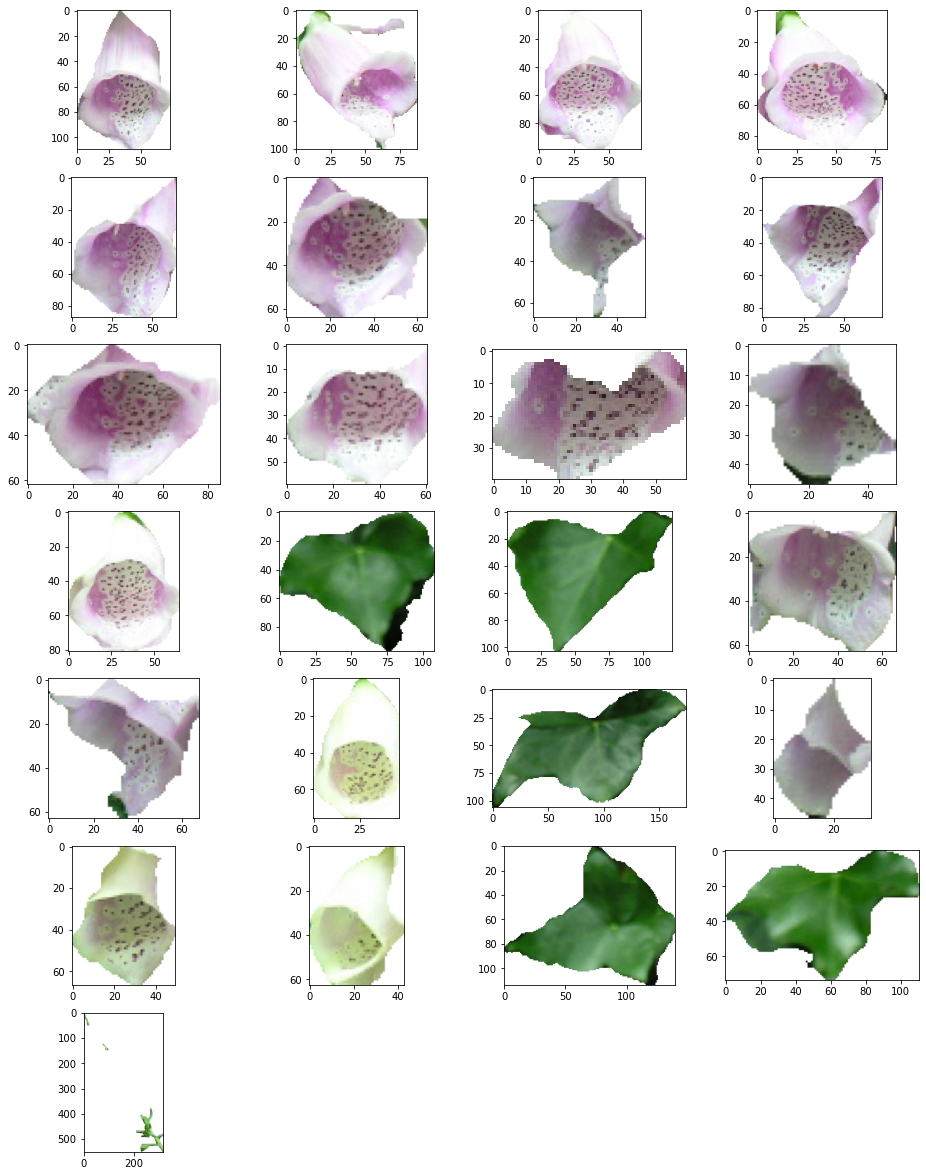

In [15]:
# Render all objects:
image_pixels = np.array(labelled_img.image_source.image_as_array_or_pil())
object_images = labels.extract_label_images(image_pixels, label_class_set=None)
n_cols = 4
n_rows = int(math.ceil(float(len(object_images)) / n_cols))
plt.figure(figsize=(16,n_rows*3))
    
for i, img in enumerate(object_images):
    plt.subplot(n_rows, n_cols, i + 1)
    plt.imshow(img)
plt.show()

Extract objects separately by class:

Extracted objects of class 'flower':


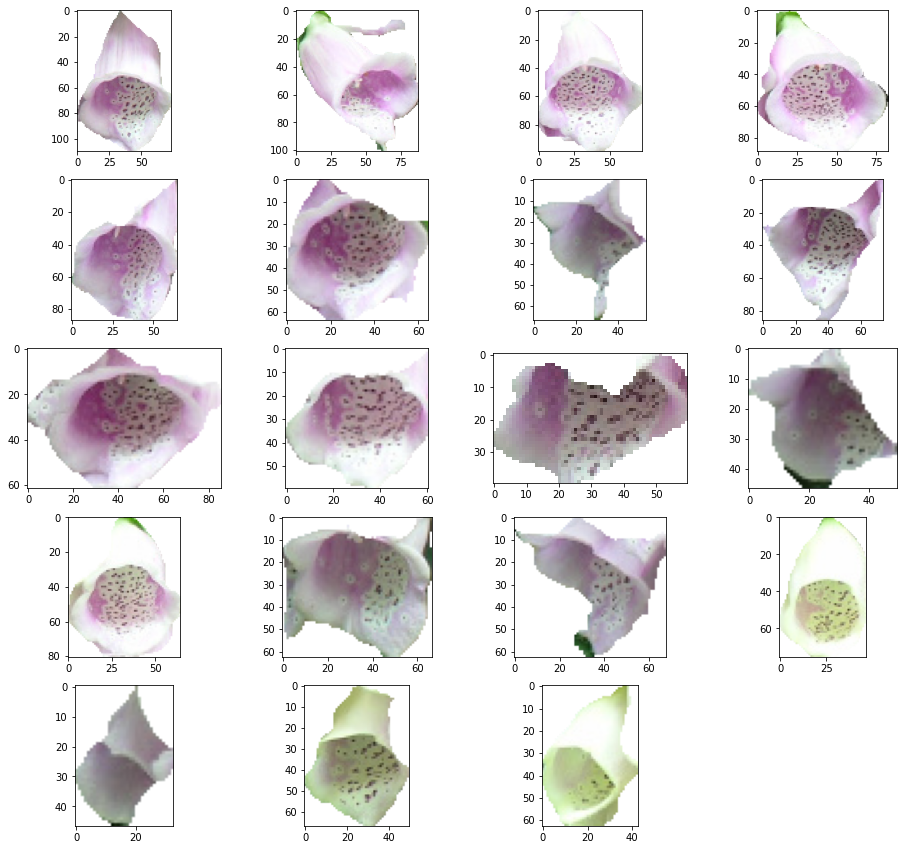

Extracted objects of class 'leaf':


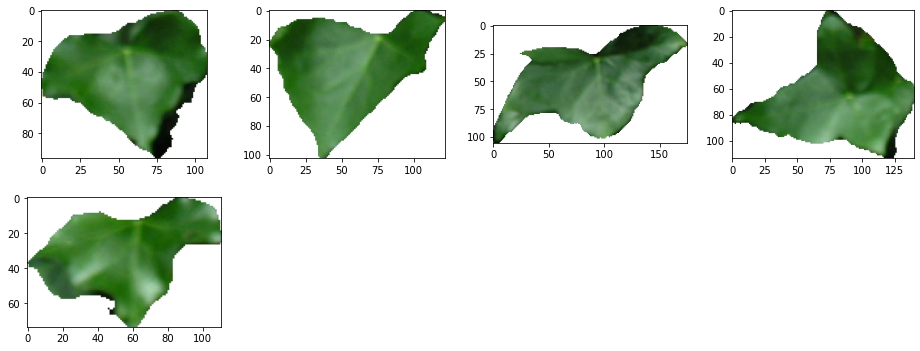

Extracted objects of class 'stem':


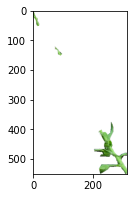

In [16]:
for cls in ['flower', 'leaf', 'stem']:
    print('Extracted objects of class \'{0}\':'.format(cls))
    object_images = labels.extract_label_images(image_pixels, label_class_set=[cls])
    n_cols = 4
    n_rows = int(math.ceil(float(len(object_images)) / n_cols))
    plt.figure(figsize=(16,n_rows*3))

    for i, img in enumerate(object_images):
        plt.subplot(n_rows, n_cols, i + 1)
        plt.imshow(img)
    plt.show()

### Convenience methods

We also note that the labelled image classes (`AbstractLabelledImage`, etc) provide convenience methods that wrap `render_label_classes` and `render_label_instances` such that you don't have to pass in the image shape:

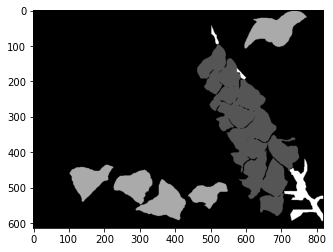

In [17]:
labels_2d = labelled_img.render_label_classes(
    label_classes={'flower' : 1, 'leaf' : 2, 'stem' : 3}, multichannel_mask=False)
plt.imshow(labels_2d, cmap='gray')
plt.show()

Similarly the `extract_label_images` wrapper does not require you to pass in the image pixel data:

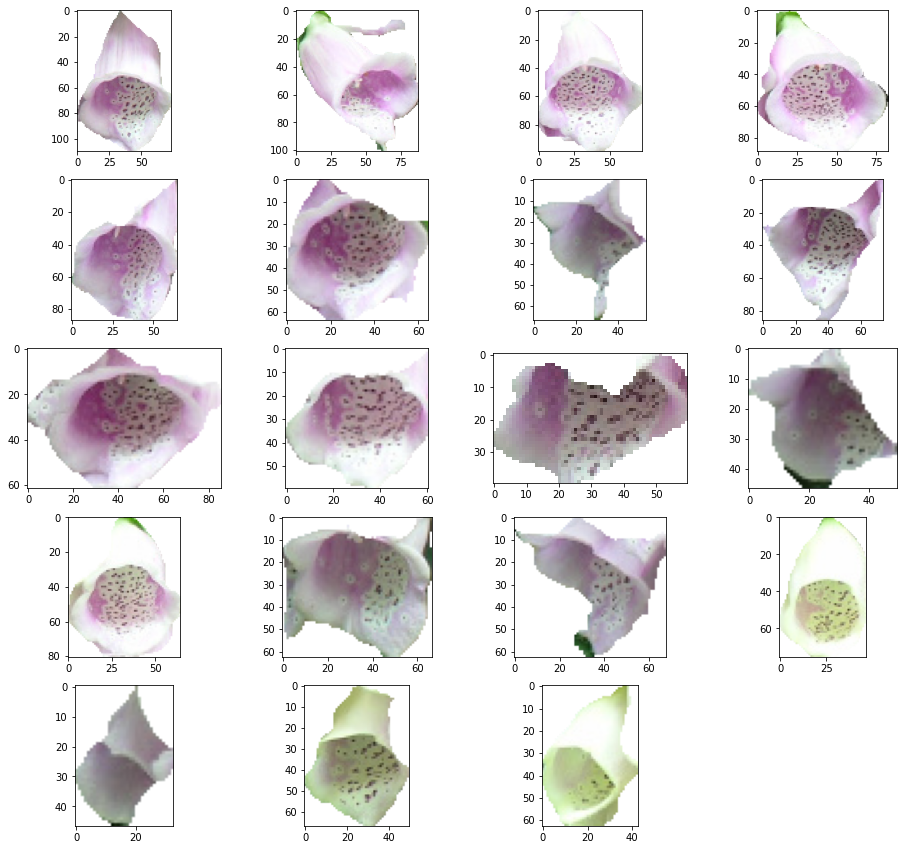

In [18]:
object_images = labelled_img.extract_label_images(label_class_set=['flower'])

n_cols = 4
n_rows = int(math.ceil(float(len(object_images)) / n_cols))
plt.figure(figsize=(16,n_rows*3))

for i, img in enumerate(object_images):
    plt.subplot(n_rows, n_cols, i + 1)
    plt.imshow(img)
plt.show()


## Filtering and merging labels

`ImageLabels` instances can be filtered and merged.

You can walk the labels in an `ImageLabels` instance as it were a list. Determine which labels you wish to retain and pass their indices to the `retain` method:

indices_of_trees=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 15, 16, 17, 19, 20, 21]
indices_of_stem=[24]


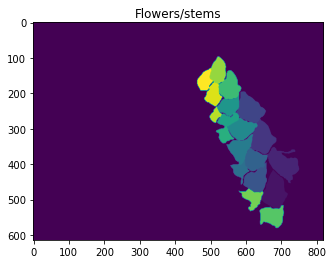

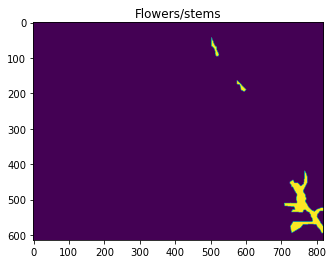

In [19]:
labels = labelled_img.labels

indices_of_flowers = [i for i, label in enumerate(labelled_img.labels) if label.classification == 'flower']
print('indices_of_trees={}'.format(indices_of_flowers))

indices_of_stem = [i for i, label in enumerate(labelled_img.labels) if label.classification == 'stem']
print('indices_of_stem={}'.format(indices_of_stem))

just_the_flowers = labels.retain(indices_of_flowers)
just_the_stem = labels.retain(indices_of_stem)

labels_2d, label_cls = just_the_flowers.render_label_instances(
    label_classes={'flower' : 1, 'leaf': 2, 'stem': 3}, image_shape=image_shape)
plt.figure()
plt.title('Flowers/stems')
plt.imshow(labels_2d)
plt.show()


labels_2d, label_cls = just_the_stem.render_label_instances(
    label_classes={'flower' : 1, 'leaf': 2, 'stem': 3}, image_shape=image_shape)
plt.figure()
plt.title('Flowers/stems')
plt.imshow(labels_2d)
plt.show()




We can merge labels toghether with the `ImageLabels.merge` class method:

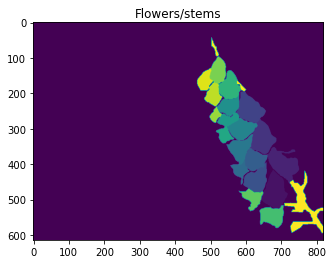

In [20]:
flowers_and_stems = labelling_tool.ImageLabels.merge(just_the_flowers, just_the_stem)

labels_2d, label_cls = flowers_and_stems.render_label_instances(
    label_classes={'flower' : 1, 'leaf': 2, 'stem': 3}, image_shape=image_shape)
plt.figure()
plt.title('Flowers/stems')
plt.imshow(labels_2d)
plt.show()

## Getting the label class and meta-data

The label class is accessible via the `classification` attribute, while the meta-data is accessible via `anno_data`.

The label class is chosen by the user using the 'Change class' drop down in the labeller UI.

The meta-data is arbitrary, with the fields and a description of their UI controls given to the labeller. Our example applications specify `quality`, `visibility` and `material` annotations.

Each label has an `object_id` that is a concatenation of the UUID of the session in which it was created
(each time an image is presented by the labeller, a different session UUID is used) and an index. This should help uniquely identify each label.

In [21]:
# Access label class
print('Class of first label: {}'.format(labels[0].classification))
# Access meta-data
print('Meta-data of first label: {}'.format(labels[0].anno_data))
# Access meta-data fields
print('Visibility (meta-data) of first label: {}'.format(labels[0].anno_data['visibility']))
print('Good quality flag (meta-data) of first label: {}'.format(labels[0].anno_data['good_quality']))
print('Material (meta-data) of first label: {}'.format(labels[0].anno_data['material']))
# Access object ID
print('Object ID: {}'.format(labels[0].object_id))

Class of first label: flower
Meta-data of first label: {'good_quality': True, 'material': 'flowers', 'visibility': 'full'}
Visibility (meta-data) of first label: full
Good quality flag (meta-data) of first label: True
Material (meta-data) of first label: flowers
Object ID: 92a4b084-68fa-4e54-a25a-1226d910c575__34


## Label data API

The label data access API will now be demonstrated.

We are going to demonstrate loading the labels from a JSON file, although reading them along with the image as we did before will also work.

In [22]:
labels_path = pathlib.Path('images') / 'foxglove__labels.json'
labels = labelling_tool.ImageLabels.from_file(labels_path)

Show the first label:

In [23]:
print('len(labels)={}'.format(len(labels)))
print('type(labels[0])={}'.format(type(labels[0])))
print('labels[0].object_id={}'.format(labels[0].object_id))
print('labels[0].classification={}'.format(labels[0].classification))
print('labels[0].anno_data={}'.format(labels[0].anno_data))
print('labels[0].regions={}'.format(labels[0].regions))
print('labels[0]={}'.format(labels[0]))

len(labels)=25
type(labels[0])=<class 'image_labelling_tool.labelling_tool.PolygonLabel'>
labels[0].object_id=92a4b084-68fa-4e54-a25a-1226d910c575__34
labels[0].classification=flower
labels[0].anno_data={'good_quality': True, 'material': 'flowers', 'visibility': 'full'}
labels[0].regions=[array([[675., 416.],
       [674., 418.],
       [673., 421.],
       [671., 423.],
       [669., 426.],
       [665., 434.],
       [665., 436.],
       [663., 439.],
       [662., 443.],
       [662., 445.],
       [661., 448.],
       [660., 451.],
       [657., 456.],
       [656., 459.],
       [656., 463.],
       [655., 468.],
       [654., 470.],
       [651., 473.],
       [648., 480.],
       [646., 482.],
       [645., 484.],
       [644., 487.],
       [643., 491.],
       [642., 494.],
       [643., 502.],
       [646., 503.],
       [649., 507.],
       [652., 509.],
       [655., 511.],
       [657., 512.],
       [659., 512.],
       [662., 515.],
       [664., 516.],
       [666., 516

### JSON Label Format

The label data is in JSON form. An example file is included in the `images` directory. The format of the file will now be described.

```
<root>: 

{
    image_filename: <image filename as string>,
    complete: <boolean indicating if the user has marked the labels as complete>
    labels: [
        <label_object 0>,
        <label_object 1>,
        ...
        <label_object N>
    ]
}


<label_object -- where label_type=polygon>:
{
    label_class: <label class as string; identifiers used above to identify label classes>
    anno_data: <meta-data as an object, mapping identifier to value>
    label_type: 'polygon',
    regions: [
        [
            <vector2 0>,
            <vector2 1>,
            ...
            <vector2 N>
        ],
        [
            <vector2 0>,
            <vector2 1>,
            ...
            <vector2 N>
        ],

    ]
}


<vector2>:
{
    x: <x-co-ordinate as float>,
    y: <y-co-ordinate as float>
}
```
